In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib.ticker import SymmetricalLogLocator
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, brier_score_loss, roc_auc_score, average_precision_score
from sklearn.utils.estimator_checks import check_estimator
from sklearn import mixture
from sklearn.decomposition import PCA
import scipy

from msc import config
from msc.cache_handler import get_samples_df
from msc.estimators import BSLE
from msc.plot_utils import set_size
from msc.time_utils import SEC, MIN, HOUR


In [2]:
dataset_id = str(config["dataset_id"])
t_max = config["t_max"]

# load samples_df
samples_df = get_samples_df(dataset_id, with_events=False, with_time_to_event=False)

In [3]:
X = np.stack(samples_df['embedding'])

In [4]:
n_dim = 5
pca = PCA(n_components=n_dim)
transformed_X = pca.fit_transform(X)

In [5]:
transformed_X.shape

(4092, 5)

In [6]:
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm.fit(transformed_X)

GaussianMixture(n_components=4, random_state=42)

In [7]:
coordinates = [np.linspace(-10.0, 10.0, 30) for _ in range(n_dim)]
grid = np.meshgrid(*coordinates)
XX = np.stack([g.ravel() for g in grid]).T

In [8]:
scores = gmm.score_samples(XX)

In [9]:
Z = scores.reshape(grid[0].shape)

In [10]:
Z.shape

(30, 30, 30, 30, 30)

In [11]:
integrate_over = tuple(range(2, n_dim))  # basic
# integrate_over = (1, 2, 4) # alt

In [12]:
integrated_Z = scipy.special.logsumexp(Z, axis=integrate_over)

In [13]:
integrated_Z.shape

(30, 30)

In [19]:
norm = SymLogNorm(vmin=np.min(integrated_Z), vmax=np.log10(0.5), linthresh=0.03)
levels = -np.flip(np.logspace(0, np.log10(-np.min(integrated_Z)), 20))

In [20]:
plt_grid = np.meshgrid(*coordinates[0:2])

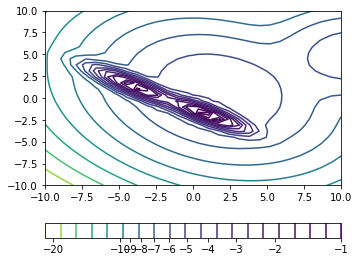

In [21]:
fig = plt.figure(figsize=set_size(width=384, height_scale=1.4))
CS = plt.contour(plt_grid[0], plt_grid[1], integrated_Z, cmap='viridis_r', levels=levels)
CB = plt.colorbar(CS, location="bottom",ticks = SymmetricalLogLocator(linthresh=0.03, base=10, subs=range(10)))


In [22]:
def plot_de_hdr(de, thresh, ax=None):
    """
    plot density estimator highest density region (HDR) above threshold `thresh`.
    """
    if ax is None:
        ax = plt.gca()

    # define x and y limits
    x = np.linspace(-10.0, 10.0, 200)
    y = np.linspace(-10.0, 10.0, 200)
    n_dims = 8
    coordinates = [np.linspace(-10.0, 10.0, 200) for _ in range(n_dims)]
    
    # create meshgrid
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = de.score_samples(XX)
    Z = Z.reshape(X.shape)

    # plot contour
    norm = SymLogNorm(vmin=np.min(Z), vmax=np.log10(0.5), linthresh=0.03)
    levels = -np.flip(np.logspace(0, np.log10(-np.min(Z)), 20))
    CS = ax.contour(X, Y, Z, norm=norm, cmap="viridis_r", levels=levels)

    CB = plt.colorbar(
        CS,
        location="right",
        ticks=SymmetricalLogLocator(linthresh=0.03, base=10, subs=range(10)),
    )
    CB.set_label("log-likelihood")

    # add axes annotations
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    plt.savefig(
        f"{config['path']['figures']}/density_estimation/hdr.pdf", bbox_inches="tight"
    )
    return ax


ValueError: X has 2 features, but GaussianMixture is expecting 5 features as input.

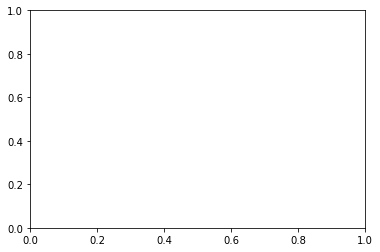

In [23]:
plot_de_hdr(gmm, 0.1)